In [101]:
%pylab inline
import numpy as np
import seaborn as sns
sns.set(style="white", color_codes=True, font_scale=1.5)

Populating the interactive namespace from numpy and matplotlib


# Worm-like chain model
Force-extension curves obtained from AFM experiments are often fitted to this simple polymer model, which is approximated as follows


$F(x)=\frac{k_BT}{p}\bigg(\frac{1}{4(1-x/L)^2}+\frac{1}{4}-\frac{x}{L}\bigg)$


In this expression we find that the force $F$ at polymer extension $x$ can be expressed in terms of the persistence length $p$ and the contour length $L$. 

In [135]:
def wlc_force(x, L, p):
    kBT = 8.314e-3*300
    invL = 1./L
    return kBT/p*0.25/(1-(x*invL)**2 + 0.25 - x*invL)

The figure below shows how the model reproduces a typical force-extension pattern.

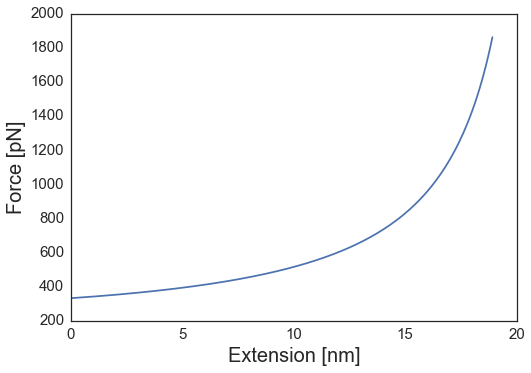

In [103]:
fig, ax = plt.subplots()
x = np.arange(0,19,0.1)
ax.plot(x, wlc_force(x, 30.,0.4)*1e3)
ax.set_xlabel('Extension [nm]', size=20)
_ = ax.set_ylabel('Force [pN]', size=20)

Next we load a characteristic sawtooth trace from an experiment on titin.

 fitting data to wlc_force
      number of parameters: 2
     initial parameters: [2.5, 0.4]
     fitted parameters: [ -1.07284007e+09   8.82448442e-03]
     fitting errors: [  1.65349605e+15   7.76413458e-04]



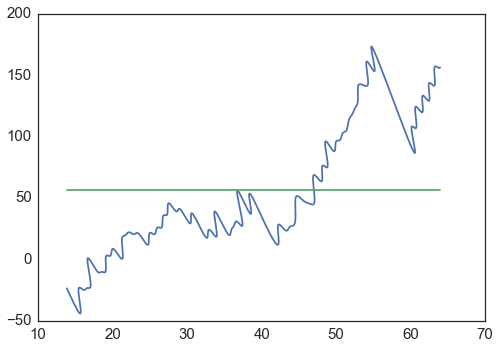

In [141]:
force_extension = np.array([(float(x.split()[0]), float(x.split()[1])) \
                   for x in open('HumanGoodTrace.txt', 'r').readlines()])
force_extension = force_extension[650:1400]
fig, ax = plt.subplots()
ax.plot(force_extension[0:,0], force_extension[:,1])
fitwlc = Fit(wlc_force, force_extension[:,0], force_extension[:,1], p0 = [2.5,0.4])
ax.plot(force_extension[:,0], fitwlc(force_extension[:,0]))


In [104]:
import inspect
from scipy.optimize import curve_fit

class Fit():
    def __init__(self, formula, x, y, p0=None, error=None):
        self.formula = formula
        print " fitting data to %s"%formula.__name__
        self.create_params(p0)
        print "     initial parameters:",self.p0
        self.fit_function(x,y, error=error)
        print "     fitted parameters:",self.popt
        print "     fitting errors:",np.sqrt(np.diag(self.pcov))
        #self.calc_r2(y,self.formula(x,*self.popt))
        #print "     R**2: %g "%self.r2
        print ""

    def __call__(self,t):
        return self.formula(t,*self.popt)

    def create_params(self,p0=None):
        """ create parameters """
        # define number of parameters
        self.nparams = len(inspect.getargspec(self.formula)[0]) - 1
        print "      number of parameters: %g"%self.nparams
        # check for user defined initial parameters
        if not p0:
            self.p0 = np.random.random(self.nparams)
        else:
            if len(p0) != self.nparams:
                print " Wrong number of initial parameters",len(p0)
                print "          %g required"%self.nparams
                sys.exit(1)
            self.p0 = p0

    def fit_function(self,x,y,p0=None,error=None):
        """ fit the data to the chosen functional form """
        popt, pcov = curve_fit(self.formula, x, y, p0=self.p0, sigma=error, maxfev = self.nparams*1000000)
        self.popt = popt
        self.pcov = pcov

    def calc_r2(self,y,ycalc):
        """ define goodness of fit metric """
        sse = np.sum((y-ycalc)**2)
        sst = np.sum((y-np.mean(y))**2)
        self.r2 = 1 - (sse/sst)*(len(y)-1)/(len(y)-self.nparams)

Next we load a characteristic sawtooth pattern from an MD simulation trajectory that we will fit to the worm-like chain model.

 fitting data to wlc_force
      number of parameters: 2
     initial parameters: [15, 0.002]
     fitted parameters: [  1.21997418e+01   1.06031738e-02]
     fitting errors: [ 0.04356795  0.00023582]



(0, 120)

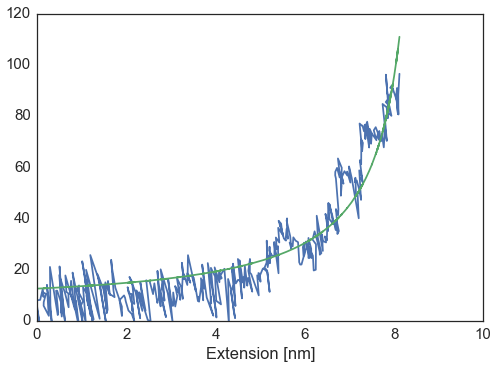

In [125]:
force_extension = np.array([(float(x.split()[0]), float(x.split()[1])) \
                   for x in open('pull_x_vs_f.dat', 'r').readlines()])
fig, ax = plt.subplots()
force_extension = force_extension[:460]
fitwlc = Fit(wlc_force, force_extension[:,0], force_extension[:,1], p0 = [15,0.002])
ax.plot(force_extension[:,0], force_extension[:,1])
ax.plot(force_extension[:,0], fitwlc(force_extension[:,0]))
#for i in [0.001, 0.002, 0.003, 0.004, 0.005]:
#    ax.plot(force_extension[:,0], wlc_force(force_extension[:,0], 15, i))
ax.set_xlabel('Extension [nm]')
ax.set_xlim(0,10)
ax.set_ylim(0,120)